In [1]:
from osgeo import gdal, ogr
import os
import subprocess as sp
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import numpy.ma as ma
from pandas.tseries import offsets
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import img_tiles
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import subprocess as sp
from matplotlib.transforms import offset_copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib
%matplotlib inline

In [2]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

In [3]:
def scale_bar(ax, length, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    """
    #Projection in metres, need to change this to suit your own figure
    utm = img_tiles.GoogleTiles().crs#ccrs.UTM(36)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    #Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * 500, sbcx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbcx, sbcy, str(length) + ' km', transform=utm,
            horizontalalignment='center', verticalalignment='bottom', size=16)

In [4]:
import matplotlib.colors as mcolors
import matplotlib

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
c = mcolors.ColorConverter().to_rgb

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def setMap(rasterBase):

    # Read the data and metadata
    ds = gdal.Open(rasterBase)
    #band = ds.GetRasterBand(20)
    
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #proj = ds.GetProjection()
    
    nan = ds.GetRasterBand(1).GetNoDataValue()
    if nan != None:
        data = np.ma.masked_equal(data,value=nan)
    
    xres = gt[1]
    yres = gt[5]
    
    # get the edge coordinates and add half the resolution 
    # to go to center coordinates
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    
    x = ds.RasterXSize 
    y = ds.RasterYSize  
    extent = [ gt[0],gt[0]+x*gt[1], gt[3],gt[3]+y*gt[5]]
    #ds = None
    img_extent = (extent[0], extent[1], extent[2], extent[3])
    
    # create a grid of xy coordinates in the original projection
    #xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    
    return extent, img_extent#, xy_source, proj

D:\Python27x64\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)
D:\Python27x64\lib\site-packages\cartopy\io\__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


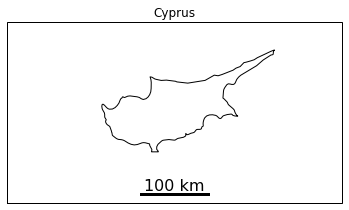

In [5]:

ax = plt.axes(projection=ccrs.Mercator())
plt.title('Cyprus')
ax.set_extent([31, 35.5, 34, 36], ccrs.Geodetic())
ax.coastlines(resolution='10m')

scale_bar(ax, 100)

plt.show()

In [6]:
cb_NDVI = make_colormap([c('#6E423C'), c('#87523B'),0.125, c('#87523B'), c('#A36C34'),0.25, 
                         c('#A36C34'), c('#BF9123'),0.375, c('#BF9123'), c('#DBC712'),0.5, 
                         c('#DBC712'), c('#B3D604'),0.625, c('#B3D604'), c('#51B004'),0.75,
                         c('#51B004'), c('#0A8701'),0.875, c('#0A8701'), c('#01611F'),1,
                         c('#01611F')])
bounds = [-.1,0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
cmap = cmap_discretize(cb_NDVI,9)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

10.0 7.02380952381
"C:\Program Files\GDAL//ogr2ogr.exe" -f "ESRI Shapefile" county.shp D:\Data\ChinaShapefile\CHN_adm//CHN_adm3.shp -clipsrc 116.84693268 34.10324112 117.42693268 33.27324112 -overwrite


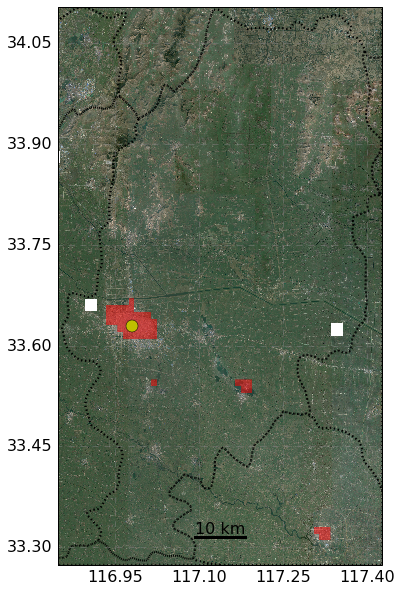

In [10]:
tiles_sat = img_tiles.GoogleTiles(style='satellite')
tiles_str = img_tiles.GoogleTiles(desired_tile_form='RGBA',style='only_streets')
web_merc = img_tiles.GoogleTiles().crs
img_extent = (116.9094,117.0444,33.56574,33.70074)
extent = [116.84693268,117.42693268,33.27324112,34.10324112]
#extent = [116.9019,117.0519,33.55824,33.70824]

# get array informaiton
mcd12q1 = r'D:\Data\NDAI_VHI_GROUNDTRUTH//mcd12q1_h27v05_v3.tif'
extent_mcd12q1, img_extent_mcd12q1 = setMap(mcd12q1)
ds = gdal.Open(mcd12q1)
#date = ds.GetMetadata()['TIFFTAG_DATETIME']
#date = '20100801'
array = ds.ReadAsArray()
#array[ma.getmaskarray(NDAI)] = 0
#nan = ds.GetRasterBand(1).GetNoDataValue()
array = ma.masked_equal(array,12)
array = np.flipud(array)

# set shape of figure
width = array.shape[0]
height = array.shape[1]
base_width = 10.
base_height = (base_width * height) / width
print base_width, base_height

# figure
fig = plt.figure(figsize=(base_height,base_width))         
#date = str(val.year) +'-'+ str(val.month).zfill(2) +'-'+ str(val.day).zfill(2)

#fig = plt.figure(figsize=(15,15))
ax = plt.subplot(111, projection=web_merc)
ax.set_extent(extent)#[-4.2, -3, 50.3, 50.7])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                  color='gray', alpha=0.5, linestyle='--')#, zorder=6)
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# prulletaria
ogr2ogr = r'C:\Program Files\GDAL//ogr2ogr.exe'
base_geom = r'D:\Data\ChinaShapefile\CHN_adm'
# county
in_file_county = base_geom + '//CHN_adm3.shp'    
outfile_county = 'county.shp'

command = [ogr2ogr, '-f', "ESRI Shapefile", outfile_county, in_file_county,'-clipsrc',
           str(extent[0]),str(extent[3]),str(extent[1]),str(extent[2]), '-overwrite']
print (sp.list2cmdline(command))
norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
norm.communicate()
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

## ADD ARRAY AS IMSHOW
#array_im = np.flipud(array[idx])
# make a color map of fixed colors
cmap = mcolors.ListedColormap(['white', 'red'])
bounds=[0,11,13]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

ax.add_image(tiles_sat, 14)
im = ax.imshow(array, origin='upper', extent=img_extent_mcd12q1,
          transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,alpha=0.5, zorder=9)
#cb = plt.colorbar(im, fraction=0.0476, pad=0.04, cmap=cmap, norm=norm, ticks=bounds,
#                  orientation='horizontal')
#cb.set_label('NDVI', size=16)
#cb.set_ticklabels(ticks)
#cb.ax.tick_params(labelsize=16) 

# ADD GOOGLE DATA

#ax.add_image(tiles_str, 13)
plt.plot(116.98, 33.63, marker='o', color='y', markersize=12,
         transform=ccrs.PlateCarree(), zorder=10)
#plt.text(0.9, 0.96,date, ha='center', va='center', 
#         transform=ax.transAxes, size=20)
# LABEL POINT
#geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
#text_transform = offset_copy(geodetic_transform, units='dots', x=-60)
#plt.text(116.98, 33.63, u'Ground Station ID 58122', size=16,
#         verticalalignment='center', horizontalalignment='right',
#         transform=text_transform,
#         bbox=dict(facecolor='wheat', boxstyle='round'))

scale_bar(ax, 10)
#plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png//Yongqiao_county_msk.png', dpi=400, 
#            bbox_inches='tight')

plt.show()
#plt.close(fig)
#fig.clf()

In [28]:
array1 = np.ones(shape=(3,3))

10.0 7.02380952381


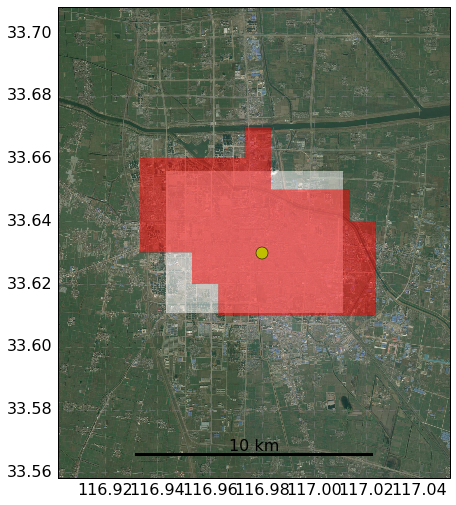

In [30]:
tiles_sat = img_tiles.GoogleTiles(style='satellite')
tiles_str = img_tiles.GoogleTiles(desired_tile_form='RGBA',style='only_streets')
web_merc = img_tiles.GoogleTiles().crs
img_extent = (116.9094+0.03375,117.0444-0.03375,33.56574+0.03375,33.70074-0.03375)
#extent = [116.84693268,117.42693268,33.27324112,34.10324112]
extent = [116.9019,117.0519,33.55824,33.70824]

# get array informaiton
mcd12q1 = r'D:\Data\NDAI_VHI_GROUNDTRUTH//mcd12q1_h27v05_v3.tif'
extent_mcd12q1, img_extent_mcd12q1 = setMap(mcd12q1)
ds = gdal.Open(mcd12q1)
#date = ds.GetMetadata()['TIFFTAG_DATETIME']
#date = '20100801'
array = ds.ReadAsArray()
#array[ma.getmaskarray(NDAI)] = 0
#nan = ds.GetRasterBand(1).GetNoDataValue()
array = ma.masked_equal(array,12)
array = np.flipud(array)

# set shape of figure
width = array.shape[0]
height = array.shape[1]
base_width = 10.
base_height = (base_width * height) / width
print base_width, base_height

# figure
fig = plt.figure(figsize=(base_height,base_width))         
#date = str(val.year) +'-'+ str(val.month).zfill(2) +'-'+ str(val.day).zfill(2)

#fig = plt.figure(figsize=(15,15))
ax = plt.subplot(111, projection=web_merc)
ax.set_extent(extent)#[-4.2, -3, 50.3, 50.7])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                  color='gray', alpha=0.5, linestyle='--')#, zorder=6)
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# # prulletaria
# ogr2ogr = r'C:\Program Files\GDAL//ogr2ogr.exe'
# base_geom = r'D:\Data\ChinaShapefile\CHN_adm'
# # county
# in_file_county = base_geom + '//CHN_adm3.shp'    
# outfile_county = 'county.shp'

# command = [ogr2ogr, '-f', "ESRI Shapefile", outfile_county, in_file_county,'-clipsrc',
#            str(extent[0]),str(extent[3]),str(extent[1]),str(extent[2]), '-overwrite']
# print (sp.list2cmdline(command))
# norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
# norm.communicate()
# ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
#                   facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

## ADD ARRAY AS IMSHOW
#array_im = np.flipud(array[idx])
# make a color map of fixed colors
# cmap = mcolors.ListedColormap(['white', 'red'])
# bounds=[0,11,13]
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

ax.add_image(tiles_sat, 14)
ax.imshow(array1, origin='upper', extent=img_extent,
               transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,alpha=0.5, zorder=9)

im = ax.imshow(array, origin='upper', extent=img_extent_mcd12q1,
          transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,alpha=0.5, zorder=9)
#cb = plt.colorbar(im, fraction=0.0476, pad=0.04, cmap=cmap, norm=norm, ticks=bounds,
#                  orientation='horizontal')
#cb.set_label('NDVI', size=16)
#cb.set_ticklabels(ticks)
#cb.ax.tick_params(labelsize=16) 

# ADD GOOGLE DATA

#ax.add_image(tiles_str, 13)
plt.plot(116.98, 33.63, marker='o', color='y', markersize=12,
         transform=ccrs.PlateCarree(), zorder=10)
#plt.text(0.9, 0.96,date, ha='center', va='center', 
#         transform=ax.transAxes, size=20)
# LABEL POINT
# geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
# text_transform = offset_copy(geodetic_transform, units='dots', x=-60)
# plt.text(116.98, 33.63, u'Ground Station ID 58122', size=16,
#          verticalalignment='center', horizontalalignment='right',
#          transform=text_transform,
#          bbox=dict(facecolor='wheat', boxstyle='round'))

scale_bar(ax, 10)
plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png//Yongqiao_city_msk_9by9_v2.png', dpi=400, 
            bbox_inches='tight')

plt.show()
#plt.close(fig)
#fig.clf()

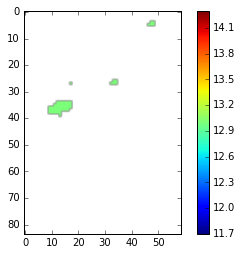

In [8]:
array_ma = ma.masked_equal(array,12)#masked_equal(array, -9)
array_ma_fl = np.flipud(array_ma)

im = plt.imshow(array_ma)
plt.colorbar(im)

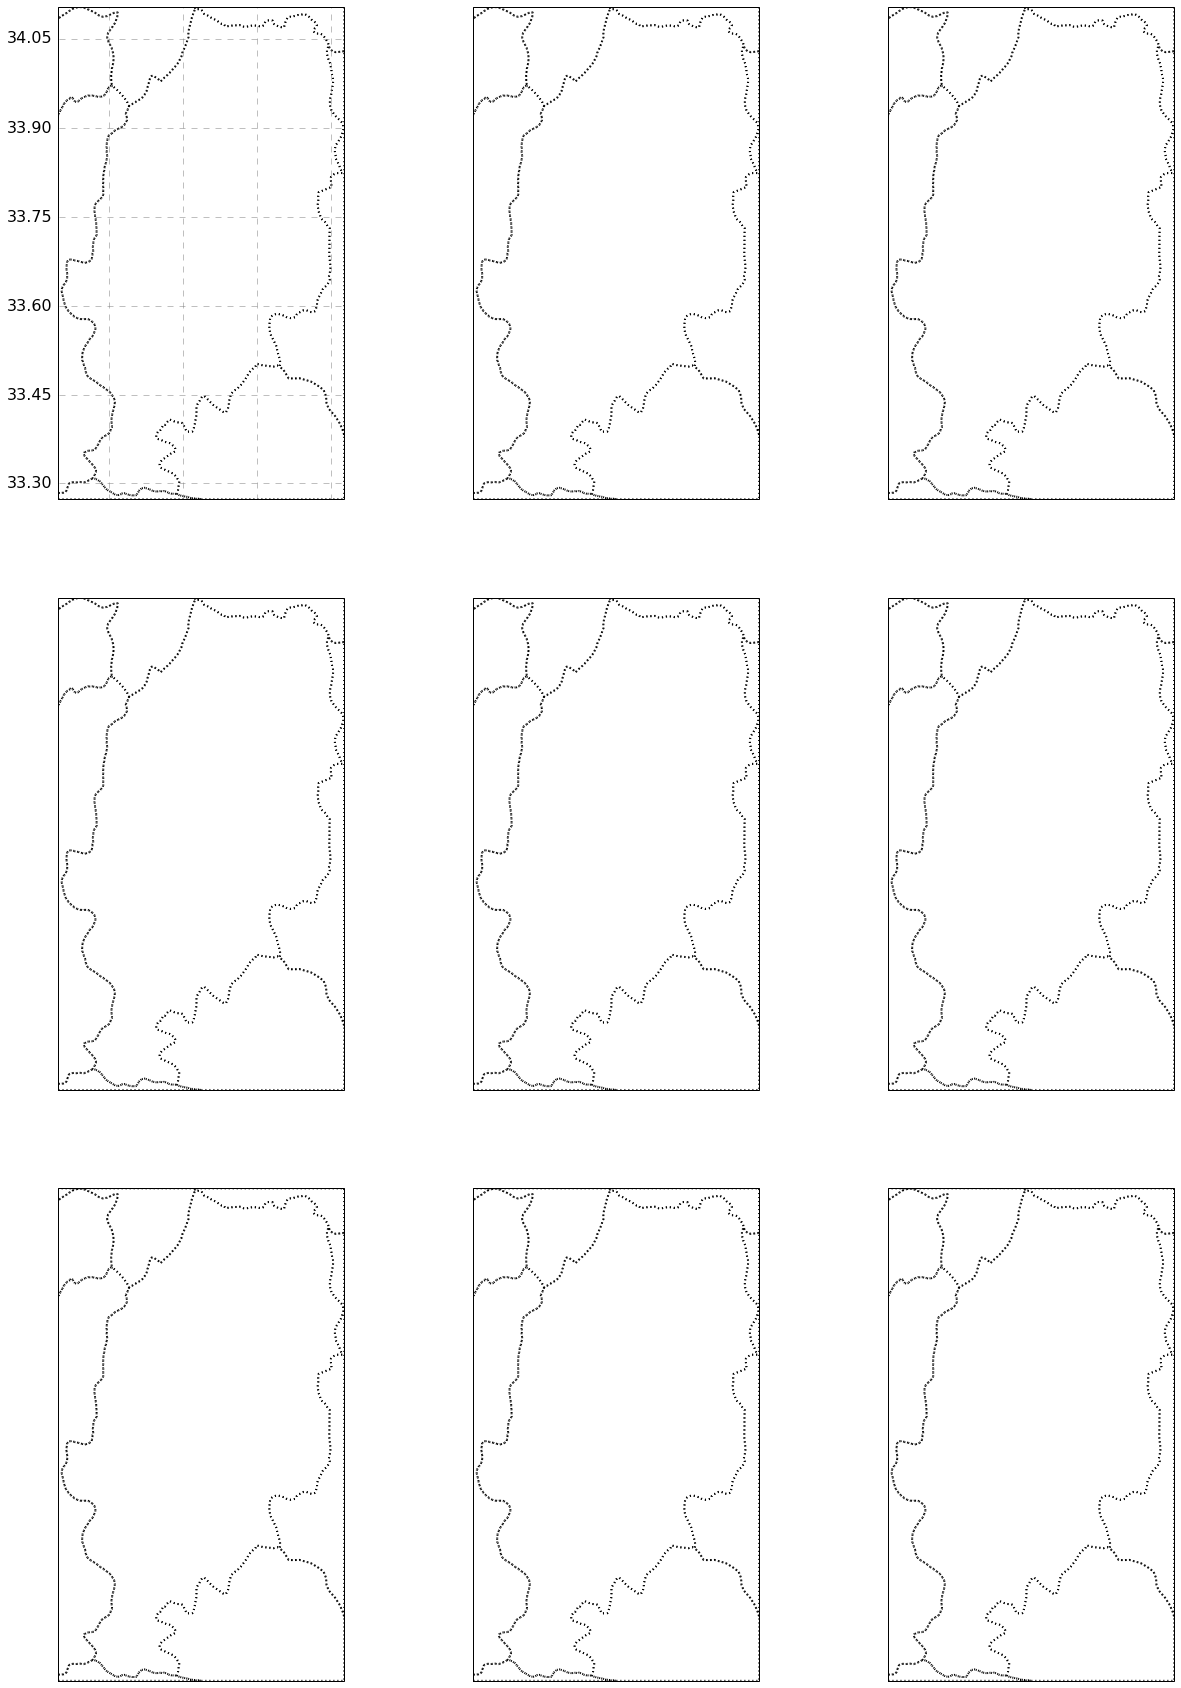

In [9]:
fig = plt.figure(figsize=(base_height*3,base_width*3))
ax = plt.subplot(331, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                  color='gray', alpha=0.5, linestyle='--')#, zorder=6)
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

ax = plt.subplot(332, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

ax = plt.subplot(333, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

ax = plt.subplot(334, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

ax = plt.subplot(335, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

ax = plt.subplot(336, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

ax = plt.subplot(337, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

ax = plt.subplot(338, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)

ax = plt.subplot(339, projection=web_merc)
ax.set_extent(extent)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
plt.show()